$$
\newcommand{P}[1]{\mathrm{P}\left( #1 \right)}
\newcommand{Pc}[2]{\mathrm{P}\left( #1 \mid #2 \right)}
\newcommand{Ec}[2]{\mathrm{E}\left( #1 \mid #2 \right)}
\newcommand{In}[2]{ #1 \perp\!\!\!\perp #2}
\newcommand{Cin}[3]{ #1 \perp\!\!\!\perp #2 \, | \, #3}
\newcommand{do}[1]{\mathrm{do}\left( #1 \right)}
\newcommand{\ci}{\perp\!\!\!\perp}
$$

# More on Counterfactual Models: Modeling Aproaches

Day 3 Module 3

## Matching Based Methods

We have seen in our smoking study example the usefulness of regression based method in estimating the causal effect ATE. 

In this case the method has done well in identifying the correct ATE - which is good, but the data generating process was specifically designed to meet the assumptions. Let's look at another cases where it might fail.

In [5]:
from __future__ import division
from sklearn.preprocessing import PolynomialFeatures
from causalinference import CausalModel

import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

Let us look at the following example, where we have nonlinear relationship:

Now for subject $i$ ($i=1,\cdots,1000$), we generate 

* the confounder $X_i \sim N(0,1)$;
* binary treatment indicator $A$ from $\text{logit}[\Pc{A_i=1}{X_i}]=1 + 2 X_i$;
* the (true) counterfactuals: 
    - $Y^0_i = 2 X_i + \epsilon_i$
    - <font color='blue'>$Y^1_i = 1 + 2 X_i - 3I(X_i<0) + \epsilon_i$</font>
    - where $\epsilon_i \sim N(0,0.3^2)$
* the observed outcome $Y_i = Y^1_i \times A_i + Y^0_i \times (1 - A_i)$

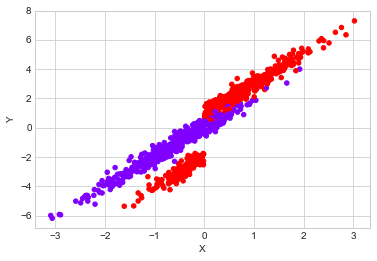

In [6]:
"""
Data Example 2
  
"""
n_samples = 1000
X = np.random.normal(size=n_samples)
p_a = np.exp(0.1 + 2 * X)/(1 + np.exp(0.1 + 2 * X))
A = np.random.binomial(n=1, p=p_a, size=n_samples)
eY = 0.3 * np.random.normal(size=n_samples)
Y0 = 2 * X + eY
Y1 = np.where(X < 0, Y0-2, Y0+1)
Y = np.where(A == 0, Y0, Y1)
data_example2 = pd.DataFrame({"X":X, "A":A, "Y":Y, "Y0":Y0, "Y1":Y1})

data_example2.plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False)

In [7]:
ctrl_grp = data_example2[data_example2.A == 0]
trt_grp = data_example2[data_example2.A == 1]
alpha = trt_grp.Y.mean() - ctrl_grp.Y.mean()
alpha_err = 1.96 * np.sqrt(
        trt_grp.Y.var() / trt_grp.shape[0] + 
        ctrl_grp.Y.var() / ctrl_grp.shape[0])
print("Estimated Association: {:.3f}".format(alpha), "({:.3f})".format(alpha_err))


theta = data_example2.Y1.mean() - data_example2.Y0.mean()
print("Simulated ATE: {:.3f}".format(theta))
theta1 = ctrl_grp.Y1.mean() - ctrl_grp.Y0.mean()
print("Simulated ATC: {:.3f}".format(theta1))
theta2 = trt_grp.Y1.mean() - trt_grp.Y0.mean()
print("Simulated ATT: {:.3f}".format(theta2))

Estimated Association: 2.508 (0.268)
Simulated ATE: -0.518
Simulated ATC: -1.391
Simulated ATT: 0.266


In [8]:
cm = CausalModel(
    Y=data_example2.Y.values, 
    D=data_example2.A.values, 
    X=data_example2.X.values)

cm.est_via_ols(adj=1)

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.544      0.086     -6.302      0.000     -0.713     -0.375



## Matching Based Method

Usually this can be overcome by using more powerful estimators . A simple, non-parametric approach, is the technique of [matching](https://en.wikipedia.org/wiki/Matching_%28statistics%29). The idea is to find for each sample which received the treatment, a similar samples which did not receive the treatment, and to directly compare these values. Exactly what you mean by "similar" will depend on your specific usecase.

In our simple example, this means we use a matched observed outcome to imput a missing counterfactual:

| index $i$ | $X_i$ | $A_i$ | $Y_i$ | $Y_i^0$ (matching) | $Y_i^1$ (matching) |
| --- | --- | --- | --- | --- | --- | 
| 1 | 0 | 0 | 4 | <font color='red'>$Y_1$</font> | <font color='green'>$Y_4$</font> |
| 2 | 0 | 0 | 3 | <font color='red'>$Y_2$</font> | <font color='green'>$Y_4$</font> |
| 3 | 0 | 0 | 5 | <font color='red'>$Y_3$</font> | <font color='green'>$Y_4$</font> |
| 4 | 0 | 1 | 8 | <font color='green'>$Y_1$</font> | <font color='red'>$Y_4$</font> |
| 5 | 1 | 0 | 2 | <font color='red'>$Y_5$</font> | <font color='green'>$Y_7$</font> |
| 6 | 1 | 0 | 4 | <font color='red'>$Y_6$</font> | <font color='green'>$Y_7$</font> |
| 7 | 1 | 1 | 8 | <font color='green'>$Y_5$</font> | <font color='red'>$Y_7$</font> |
| 8 | 1 | 1 | 6 | <font color='green'>$Y_5$</font> | <font color='red'>$Y_8$</font> |

For the smoking example, the package `causalinference` implements matching by selecting for each unit, with replacement, the most similar unit from the other treatment group and using the difference between these two units to calculate the ATE. By default, the choice of match is chosen to be the nearest neighbour in covariate space $X$, with the distances weighted by inverse variance of each dimension.

There are options to change the number of units compared and the weighting of each dimension in the match. For more details, see the [documentation](http://laurence-wong.com/software/matching).

We can compute the matching estimate with the following code

In [9]:
cm = CausalModel(
    Y=data_example2.Y.values, 
    D=data_example2.A.values, 
    X=data_example2.X.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.487      0.172     -2.827      0.005     -0.825     -0.149
           ATC     -1.353      0.235     -5.767      0.000     -1.813     -0.893
           ATT      0.289      0.222      1.307      0.191     -0.145      0.724



The confidence intervals around our estimate now contain the true ATE.

The OLS estimator fails to capture the true effect, while the matching based estimator yields the correct estimation.

`causalinference` provides a useful tool to quickly assess the overlap of the variables using the `summary_stats` property:

In [10]:
print(cm.summary_stats)


Summary Statistics

                       Controls (N_c=473)         Treated (N_t=527)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -1.239        1.548        1.269        2.675        2.508

                       Controls (N_c=473)         Treated (N_t=527)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.634        0.760        0.510        0.772        1.493



Where the Normalized difference is defined as

$\frac{\bar{X}_{T} - \bar{X}_{T}}{ (\sigma^{2}_{T} + \sigma^{2}_{C})/2 } $

While it isn't a strict statistical test, it provides some indication how much overlap there is between each covariate. Values greater than one suggest there isn't much overlap.

# Propensity Score

For dichotomous treatments, we denote the 'true' propensity score as
$e_i=e(\boldsymbol{X}_i)=\Pc{A_i=1}{X_{1i}},X_{2i},\cdots,X_{pi}$.

The propensity score has two fundamental properties in causal inference:
* **Balancing property**: Treatment assignment is conditionally independent of the covariates given the propensity score. 
    - $A_i\ci \boldsymbol{X}_i | e(\boldsymbol{X}_i)$ (sufficient dimension reduction)
* **Unconfoundedness**: Under conditional exchangeability, the counterfactual outcomes are conditionally independent given the propensity score: 
    - $Y_i^a\ci A_i | e(\boldsymbol{X}_i)$ for $a=0,1$

### Balancing Scores
In fact, propensity score is a special case of a more generally defined score function -- Balancing Score

Any function $b(\boldsymbol{X})$ of $\boldsymbol{X}$ satisfies $A \ci \boldsymbol{X}\,|\,b(\boldsymbol{X})$ is called a balancing score. 

**Theorem**:  A function $b(\boldsymbol{X})$ is a balancing score if and only if $b(\boldsymbol{X})$ is “finer” than $e(\boldsymbol{X})$ in the sense that $e(\boldsymbol{X})=f(b(\boldsymbol{X}))$ for some function $f$. 

## Inverse Propensity Score Weighting (Inverse Probability Weighting, IPW)

Remember that the problem of measuring causal inference is that we want to know the quantity $E[Y^{a}]$, but we only have access to samples from $E[Y^{a}|A=a]$.

The density of a potential outcome can be expanded to give

$P(Y^{a}) = P(Y^{a}| A = a)P(A = a)$

This suggests that we can estimate the expectation 

$E[Y^{a}] = E[\frac{Y^{a}}{P(A = a|X)}P(A=a|X)] = E[\frac{Y^{a}}{P(A=a|X)}|A=a, X]$

So if we weight each point by it's inverse propensity, we can recover the potential outcomes. The result is the [inverse propensity score weight estimator](https://en.wikipedia.org/wiki/Inverse_probability_weighting):

$\theta_{ipw} = \frac{1}{N}\left(\sum_{i \in 1} \frac{Y_{i}}{\hat{e}(X_{i})} - \sum_{i \in 0} \frac{Y_{i}}{1 - \hat{e}(X_{i})}\right)$


In our simple example, this means we weight the non-missing counterfactuals to represent the missing counterfactuals:

$\Pc{A_i=1}{X_i=0} = 1/4 \\
 \Pc{A_i=0}{X_i=0} = 3/4 \\
 \Pc{A_i=1}{X_i=1} = 1/2 \\
 \Pc{A_i=0}{X_i=1} = 1/2$, 
 
thus we have

| index $i$ | $X_i$ | $A_i$ | $Y_i$ | $Y_i^0$ (weighting) | $Y_i^1$ (weighting) |
| --- | --- | --- | --- | --- | --- | 
| 1 | 0 | 0 | 4 | <font color='red'>$Y_1$</font>$\times$<font color='green'>$\frac{4}{3}$</font> | |
| 2 | 0 | 0 | 3 | <font color='red'>$Y_2$</font>$\times$<font color='green'>$\frac{4}{3}$</font> | |
| 3 | 0 | 0 | 5 | <font color='red'>$Y_3$</font>$\times$<font color='green'>$\frac{4}{3}$</font> | |
| 4 | 0 | 1 | 8 | | <font color='red'>$Y_4$</font>$\times$<font color='green'>4</font> |
| 5 | 1 | 0 | 2 | <font color='red'>$Y_5$</font>$\times$<font color='green'>2</font> | |
| 6 | 1 | 0 | 4 | <font color='red'>$Y_6$</font>$\times$<font color='green'>2</font> | |
| 7 | 1 | 1 | 8 | | <font color='red'>$Y_7$</font>$\times$<font color='green'>2</font> |
| 8 | 1 | 1 | 6 | | <font color='red'>$Y_8$</font>$\times$<font color='green'>2</font> |


Next, let's see how it does in our simulation study:

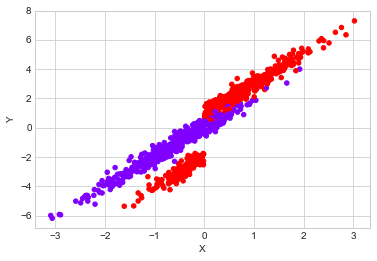

In [11]:
data_example2.plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False);

In [12]:
ctrl_grp = data_example2[data_example2.A == 0]
trt_grp = data_example2[data_example2.A == 1]
alpha = trt_grp.Y.mean() - ctrl_grp.Y.mean()
alpha_err = 1.96 * np.sqrt(
        trt_grp.Y.var() / trt_grp.shape[0] + 
        ctrl_grp.Y.var() / ctrl_grp.shape[0])
print("Estimated Association: {:.3f}".format(alpha), "({:.3f})".format(alpha_err))

theta = data_example2.Y1.mean() - data_example2.Y0.mean()
print("Simulated ATE: {:.3f}".format(theta))

Estimated Association: 2.508 (0.268)
Simulated ATE: -0.518


In practice, we never know $e(X_i)$'s and must use weights based on propensity scores estimated from logistic regression or modeling approaches instead

We can estimate the propensity using the `CausalInference` package's methods `est_propensity_s` or `est_propensity`, which uses logistic regression on the covariate to estimate propensity:

In [15]:
cm = CausalModel(
    Y=data_example2.Y.values, 
    D=data_example2.A.values, 
    X=data_example2.X.values)

cm.est_propensity_s()

propensity = cm.propensity["fitted"]

df = data_example2

df["ips"] = np.where(
    df.A == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.Y * df.ips

ipse = (
      df[df.A == 1]["ipsw"].sum() 
    - df[df.A == 0]["ipsw"].sum()
) / df.shape[0]

print("Estimated ATE (by weighting based method): {:.3f}".format(ipse))

Estimated ATE (by weighting based method): -0.462


This does well in our situation - by is very dependent on how good our estimate of the propensity score is - for the data generator we're using for this example the relationship can be described well by plain logistic regression.

$$\def \bX {\textbf {X}}$$
$$\def \balpha {\boldsymbol{\alpha}}$$
$$\def \bbeta {\boldsymbol{\beta}}$$
# Doubly Robust Weighted Estimator

In practice, it might be difficult to know either the true model for outcome, or the true model for the weights, one solutuon is  to combine the inverse propensity score weighting estimators and the linear estimator of effect size together to try and reduce the flaws in either model. 

Such a proposal is called the [doubly robust weighted estimator](https://academic.oup.com/aje/article/173/7/761/103691), or the augmented inverse propensity weighted (AIPW) estimator.

Recall two estimators we have discussed:

* Regression Based Estimator for ATE: 
    - When assumptions are satisfied, we can identify the regression of $Y$ on $A$ and $\boldsymbol{X}$, e.g. for continuous outcome, $E(Y\vert A, \bX)=m(A, \bX; \balpha)=\alpha_0 + \alpha_a A + \bX^T\boldsymbol{\alpha}_X$
    - We can estimate the mean of counterfactual $E(Y^1)$ as ${N}^{-1}\sum_{i=1}^N m(A_i=1, \bX_i; \hat\balpha)$
    - Similarly, we can estimate the mean of counterfactual $E(Y^0)$ as ${N}^{-1}\sum_{i=1}^N m(A_i=0, \bX_i; \hat\balpha)$
    - ATE can then be estimated as the difference between these two quantities
    - It requires that **the outcome model be correctly specified**
    
* Weighting Based Estimator for ATE:
    - When assumptions are satisfied, we can estimate the propensity score from the regression of $A$ on $\bX$, e.g. we postulate a logistic regression model 
    $P(A=1\vert \bX) = e(\bX; \bbeta) = \frac{\exp(\beta_0 + \bX^T\bbeta_1)}{1 + exp(\beta_0 + \bX^T\bbeta_1)}$
    - We can estimate the mean of counterfactual $E(Y^1)$ as $N^{-1}\sum_{i=1}^N (A_iY_i)/{e(\bX_i, \boldsymbol{\hat\beta})}$
    - We can estimate the mean of counterfactual $E(Y^0)$ as $N^{-1}\sum_{i=1}^N (1 - A_i)Y_i/[1 - e(\bX_i, \boldsymbol{\hat\beta})]$
    - ATE can then be estimated as the difference between these two quantities
    - It requires that **the propensity score model be correctly specified**

The Doubly Robust Estimator combines these two proposals, and estimates ATE as 


$\hat\theta_{AIPW} = \hat E(Y^1) - \hat E(Y^0) = N^{-1}\sum_{i=1}^N\left[\frac{A_iY_i}{e(\bX_i, \boldsymbol{\hat\beta})} - \frac{A_i - e(\bX_i, \boldsymbol{\hat\beta})}{e(\bX_i, \boldsymbol{\hat\beta})}m(A_i=1, \bX_i, {\hat\balpha}) \right]
    - N^{-1}\sum_{i=1}^N\left[\frac{(1 - A_i)Y_i}{1 - e(\bX_i, \boldsymbol{\hat\beta})} + \frac{A_i - e(\bX_i, \boldsymbol{\hat\beta})}{1 - e(\bX_i, \boldsymbol{\hat\beta})}m(A_i=0, \bX_i, \hat\balpha) \right]$


Intuitively, if there is big bias in either $m(A_i, \bX_i, \hat\balpha)$ or $e(\bX_i, \boldsymbol{\hat\beta})$, there is an additional term in this new estimator that takes into account the other model. 

It can be shown that if
* The regression model is incorrect but the propensity model is correct
    
    OR
* The propensity model is incorrect but the regression model is correct
    
    then $\hat\theta_{AIPW}$ is a (consistent) estimator for the ATE.

We can apply this estimator in our simulation study:

In [20]:
cm = CausalModel(
    Y=data_example2.Y.values, 
    D=data_example2.A.values, 
    X=data_example2.X.values)

cm.est_propensity_s()
cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.796      0.070    -11.327      0.000     -0.934     -0.658



# Some Practical Issues 

The causal inference tools we discussed so far require the assumptions. Yet, in practice, these assumptions can never be tested. In this section, we will discuss some considerations regarding applying counterfactual modeling approaches in practice.

## About the Positivity Assumption

When there are areas of covariate space which contains only the treated or untreated samples, i.e., there are some subgroup of patients who may hardly be assigned to one treatment arm, then the problem become difficult. We have to extrapolate the effect of the treatment - which will depend heavily on the additional assumptions we imposed on the model structure. 

We may look at the following example:

Now for subject $i$ ($i=1,⋯,1000$), we generate

* the confounder $X_i \sim \text{Uniform}(0,1)$;
* binary treatment indicator $A \sim \text{Bernoulli}(p_{a,i})$, with 

$p_{a,i} = \left\{
\begin{array}{cc}
0 & \text{if }X_i<0.1
\\
X_i & \text{if }0.1\leq X_i \leq 0.9
\\
1 & \text{if }X_i > 0.9
\end{array}
\right.$
* the (true) counterfactuals: 
    - $Y^0_i = -4(X_i - 0.3)\times I(X_i\geq 0.3) + \epsilon_i$
    - $Y^1_i = 1 - 4(X_i - 0.7)\times I(X_i< 0.7) + \epsilon_i$
    - where $\epsilon_i \sim N(0,0.3^2)$
* the observed outcome $Y_i = Y^1_i \times A_i + Y^0_i \times (1 - A_i)$

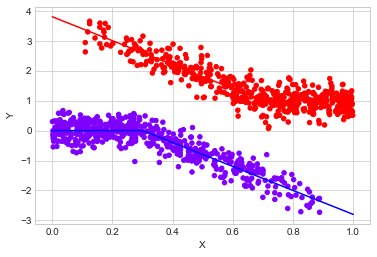

In [23]:
"""
Data Example 3
  
"""
n_samples = 1000
X = np.random.uniform(size=n_samples)
p_a = np.where(X < 0.1, 0, np.where(X > 0.9, 1, X))
A = np.random.binomial(n=1, p=p_a, size=n_samples)
eY = 0.3 * np.random.normal(size=n_samples)
Y0 = np.where(X >= 0.3, -4*(X - 0.3), 0) + eY
Y1 = np.where(X < 0.7,  -4*(X - 0.7), 0) + 1 + eY
Y = np.where(A == 0, Y0, Y1)
data_example3 = pd.DataFrame({"X":X, "A":A, "Y":Y, "Y0":Y0, "Y1":Y1})

data_example3.plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False)
# latent traj
t = np.linspace(0,1,100)
y0 =  np.where(t >= 0.3, -4*(t - 0.3), 0)
y1 =  np.where(t < 0.7,  -4*(t - 0.7), 0) + 1
plt.plot(t, y0, "b")
plt.plot(t, y1, "r")

In [24]:
ctrl_grp = data_example3[data_example3.A == 0]
trt_grp = data_example3[data_example3.A == 1]
alpha = trt_grp.Y.mean() - ctrl_grp.Y.mean()
alpha_err = 1.96 * np.sqrt(
        trt_grp.Y.var() / trt_grp.shape[0] + 
        ctrl_grp.Y.var() / ctrl_grp.shape[0])
print("Estimated Association: {:.3f}".format(alpha), "({:.3f})".format(alpha_err))

theta = data_example3.Y1.mean() - data_example3.Y0.mean()
print("Simulated ATE: {:.3f}".format(theta))

Estimated Association: 1.892 (0.088)
Simulated ATE: 2.954


In [25]:
# OLS estimator
cm = CausalModel(
    Y=data_example3.Y.values, 
    D=data_example3.A.values, 
    X=data_example3.X.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.766      0.030     92.929      0.000      2.708      2.824
           ATC      2.775      0.035     79.733      0.000      2.707      2.844
           ATT      2.756      0.035     78.858      0.000      2.687      2.824



In [26]:
# Matching estimator
cm.est_via_matching()
print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.766      0.030     92.929      0.000      2.708      2.824
           ATC      2.775      0.035     79.733      0.000      2.707      2.844
           ATT      2.756      0.035     78.858      0.000      2.687      2.824

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.875      0.091     31.426      0.000      2.696      3.054
           ATC      2.800      0.139     20.108      0.000      2.527      3.073
           ATT      2.959      0.104     28.451      0.000      2.755      3.162



### Trimming

A simple solution is to only make predictions for the counterfactual in regions where there is a good overlap, or "trim" points where there is not good overlap. For high dimensional data "good overlap" can be difficult to define - using just the propensity score to define overlap is one way to solve this. 

`CausalInference` offers a method to trim the data based on the propensity score

In [27]:
# OLS estimator
cm = CausalModel(
    Y=data_example3.Y.values, 
    D=data_example3.A.values, 
    X=data_example3.X.values)

cm.est_propensity_s()
cm.trim_s()
cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.816      0.054     51.699      0.000      2.709      2.922
           ATC      2.768      0.068     40.701      0.000      2.635      2.901
           ATT      2.865      0.069     41.489      0.000      2.730      3.001



We can look at the remaining data in the following way

Simulated ATE: 2.831


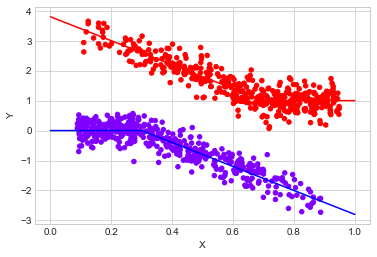

In [28]:
# mask out data ignored by the 
propensity = cm.propensity["fitted"]
cutoff = cm.cutoff
mask = (propensity > cutoff) &  (propensity < 1 - cutoff)

# plot the data
data_example3[mask].plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False)

# latent traj
t = np.linspace(0,1,100)
y0 =  np.where(t >= 0.3, -4*(t - 0.3), 0)
y1 =  np.where(t < 0.7,  -4*(t - 0.7), 0) + 1
plt.plot(t, y0, "b")
plt.plot(t, y1, "r")

filter_example3 = data_example3[mask]
theta1 = filter_example3.Y1.mean() - filter_example3.Y0.mean()
print("Simulated ATE: {:.3f}".format(theta1))

It does quite well in there cases.

When we apply trimming, we are explicitly saying that it is only possible to make causal inferences for samples in some subgroup of patients. For samples outside these regions, we cannot say anything about the ATE.

### Stratification

Another use of the propensity score is the stratification, or blocking, estimator. It consist of grouping the data points into groups of similar propensity, and to estimate the ATE within these groups. Again, `CausalInference` provides a nice interface to achieve this. 

We use the `stratify` (for user defined stata boundaries) or `stratify_s` (to automatically choose the boundaries) methods to determine the strata:

In [18]:
cm = CausalModel(
    Y=data_example3.Y.values, 
    D=data_example3.A.values, 
    X=data_example3.X.values)

cm.est_propensity_s()
cm.stratify_s()

print(cm.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.002     0.117       117         9     0.058     0.086    -1.355
         2     0.117     0.240       105        20     0.176     0.186    -2.009
         3     0.240     0.550       153        97     0.385     0.395    -2.063
         4     0.551     0.694        49        76     0.623     0.626     0.824
         5     0.694     0.811        32        93     0.751     0.758     1.033
         6     0.811     0.919        14       111     0.862     0.865     1.098
         7     0.920     0.998         3       121     0.967     0.962     0.899



and the `est_via_blocking` method to combine the estimates of these strata into one overall ATE:

In [19]:
cm.est_via_blocking()
print(cm.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.560      0.032    -17.508      0.000     -0.622     -0.497
           ATC     -1.457      0.041    -35.733      0.000     -1.537     -1.377
           ATT      0.246      0.039      6.262      0.000      0.169      0.322



Which again works well.

Stratify the data into groups by propensity score is useful when we don't have any prior knowledge of what constitutes "similar" units, however it is not the only way. If you have prior knowledge the different groups of your samples are likely to be affected by the intervention in similar ways, it makes sense to split you samples into these groups before estimating the ATE, then pooling the results to get a global ATE. 